In [10]:
import gym 
import torch
import torch.nn as nn
import numpy as np
from collections import deque

from matplotlib import pyplot as plt

In [11]:
#Import the environment.
env = gym.make('CartPole-v1')

In [12]:
#Define and build the DQN.

#Some parameters and hyperparameters.
input_shape = env.observation_space.shape[0]
output_shape = env.action_space.n

hidden_size = 64 
learning_rate = 0.0001

#Build a basic network.
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

class Qnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.output_shape = output_shape
        
        self.input_layer = nn.Linear(*self.input_shape, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, self.output_shape)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.loss = nn.MSELoss()
        self.to(device)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.input_layer(x))
        x = torch.nn.functional.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        
        return(x)

In [13]:
#Define and build the memory for replay.

#Hyperparameters.
memory_size = 10000
batch_size = 1500

#Definition.
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [14]:
#Define the agent.

#Hyperparameters.
gamma = 0.95
e_max = 1.0
e_min = 0.001
e_decay = 0.9995

#Definition.
class Agent():
    def __init__(self):
        self.memory = Memory(memory_size)
        self.epsilon = e_max
        self.policy_network = Qnet()
        self.target_network = Qnet()
        
    def choose_action(self, observation):
        if np.random.rand() < self.epsilon:
            return env.action_space.sample()
        state = torch.tensor(observation).float().detach()
        state = state.to(device)
        state = state.unsqueeze(0)
        q_values = self.policy_network(state)
        return torch.argmax(q_values).item()
    
    def learn(self):
        if len(self.memory.buffer) < batch_size:
            return

        batch = self.memory.sample(batch_size)
        states = torch.tensor(np.array([each[0] for each in batch]), dtype=torch.float32).to(device)
        actions = torch.tensor(np.array([each[1] for each in batch]), dtype=torch.long).to(device)
        rewards = torch.tensor(np.array([each[2] for each in batch]), dtype=torch.float32).to(device)
        states_ = torch.tensor(np.array([each[3] for each in batch]), dtype=torch.float32).to(device)
        dones = torch.tensor(np.array([each[4] for each in batch]), dtype=torch.bool).to(device)
        batch_indices = np.arange(batch_size, dtype=np.int64)
        
        q_values = self.policy_network(states)
        #next_q_values = self.policy_network(states_) #No target net update.
        next_q_values = self.target_network(states_)
        
        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0]
        
        q_target = rewards + gamma * predicted_value_of_future * dones
        
        self.epsilon *= e_decay
        self.epsilon = max(e_min, self.epsilon)
        
        loss = self.policy_network.loss(q_target, predicted_value_of_now)
        self.policy_network.optimizer.zero_grad()
        loss.backward()
        self.policy_network.optimizer.step()
            
    
    def return_epsilon(self):
        return self.epsilon
    
    def update_target_net(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

In [17]:
#Now train the agent.

#Hyperparameters.
episodes = 10000
target_fraction = 100

#Some plotting.
episode_number = []
episode_rewards = []

#Initialize the agent.
agent = Agent()

for i in range(episodes):
    state = env.reset()
    #state = np.reshape(state, [1, input_shape])
    
    #Keep track of cumulative reward.
    cum_reward = 0
    
    while True:
        #env.render()
        action = agent.choose_action(state) #Choose next action according to the annealed e-greedy policy.
        state_, reward, done, _ = env.step(action) #Act on it.
        #state_ = np.reshape(state_, [1, input_shape]) 
        agent.memory.add((state, action, reward, state_, 1-done)) #Add the experience to the memory.
        state = state_ #Progress the state to the next.
        cum_reward += reward #Increase the reward.
        
        if done:
            if i % target_fraction == 0:
                agent.update_target_net() #Update the target net a fraction of the time.
            #if agent.epsilon == e_min and cum_reward < np.mean(episode_rewards[-10:]):
            #    pass
            agent.learn() #Learn from the memory.
            
            if i % 10 == 0:
                print("Episode {} Reward {} Epsilon {}".format(i, cum_reward, agent.return_epsilon()))
            break
        
            episode_number.append(i)
            episode_rewards.append(cum_reward)

plt.plot(episode_number, episode_rewards)

Episode 0 Reward 57.0 Epsilon 1.0
Episode 10 Reward 32.0 Epsilon 1.0
Episode 20 Reward 29.0 Epsilon 1.0
Episode 30 Reward 25.0 Epsilon 1.0
Episode 40 Reward 22.0 Epsilon 1.0
Episode 50 Reward 11.0 Epsilon 1.0
Episode 60 Reward 16.0 Epsilon 1.0
Episode 70 Reward 9.0 Epsilon 0.9970037475009376
Episode 80 Reward 12.0 Epsilon 0.9920299301136144
Episode 90 Reward 25.0 Epsilon 0.9870809259323243
Episode 100 Reward 11.0 Epsilon 0.9821566111698136
Episode 110 Reward 13.0 Epsilon 0.9772568626563747
Episode 120 Reward 17.0 Epsilon 0.972381557836764
Episode 130 Reward 29.0 Epsilon 0.9675305747671379
Episode 140 Reward 15.0 Epsilon 0.9627037921120016
Episode 150 Reward 13.0 Epsilon 0.9579010891411742
Episode 160 Reward 30.0 Epsilon 0.9531223457267703
Episode 170 Reward 28.0 Epsilon 0.9483674423401935
Episode 180 Reward 23.0 Epsilon 0.9436362600491477
Episode 190 Reward 17.0 Epsilon 0.938928680514662
Episode 200 Reward 9.0 Epsilon 0.9342445859881309
Episode 210 Reward 13.0 Epsilon 0.929583859308369

Episode 1630 Reward 38.0 Epsilon 0.45694336878493574
Episode 1640 Reward 74.0 Epsilon 0.4546637857057534
Episode 1650 Reward 29.0 Epsilon 0.4523955749308212
Episode 1660 Reward 86.0 Epsilon 0.4501386797263858
Episode 1670 Reward 34.0 Epsilon 0.4478930436417254
Episode 1680 Reward 49.0 Epsilon 0.4456586105077373
Episode 1690 Reward 62.0 Epsilon 0.44343532443553363
Episode 1700 Reward 63.0 Epsilon 0.44122312981504286
Episode 1710 Reward 61.0 Epsilon 0.4390219713136189
Episode 1720 Reward 37.0 Epsilon 0.4368317938746575
Episode 1730 Reward 62.0 Epsilon 0.4346525427162186
Episode 1740 Reward 44.0 Epsilon 0.43248416332965656
Episode 1750 Reward 79.0 Epsilon 0.4303266014782564
Episode 1760 Reward 82.0 Epsilon 0.4281798031958776
Episode 1770 Reward 44.0 Epsilon 0.4260437147856038
Episode 1780 Reward 58.0 Epsilon 0.42391828281840016
Episode 1790 Reward 37.0 Epsilon 0.42180345413177645
Episode 1800 Reward 51.0 Epsilon 0.4196991758284578
Episode 1810 Reward 22.0 Epsilon 0.41760539527506135
Episo

Episode 3180 Reward 166.0 Epsilon 0.21047474066897506
Episode 3190 Reward 161.0 Epsilon 0.20942473165210254
Episode 3200 Reward 144.0 Epsilon 0.20837996088344932
Episode 3210 Reward 210.0 Epsilon 0.20734040223062608
Episode 3220 Reward 341.0 Epsilon 0.2063060296916118
Episode 3230 Reward 286.0 Epsilon 0.2052768173941036
Episode 3240 Reward 252.0 Epsilon 0.20425273959486928
Episode 3250 Reward 248.0 Epsilon 0.20323377067910361
Episode 3260 Reward 190.0 Epsilon 0.20221988515978762
Episode 3270 Reward 239.0 Epsilon 0.20121105767705114
Episode 3280 Reward 245.0 Epsilon 0.20020726299753833
Episode 3290 Reward 408.0 Epsilon 0.19920847601377664
Episode 3300 Reward 224.0 Epsilon 0.19821467174354895
Episode 3310 Reward 309.0 Epsilon 0.19722582532926838
Episode 3320 Reward 256.0 Epsilon 0.19624191203735675
Episode 3330 Reward 169.0 Epsilon 0.1952629072576259
Episode 3340 Reward 199.0 Epsilon 0.19428878650266218
Episode 3350 Reward 323.0 Epsilon 0.19331952540721387
Episode 3360 Reward 500.0 Epsil

Episode 4710 Reward 165.0 Epsilon 0.09792230276886875
Episode 4720 Reward 175.0 Epsilon 0.09743379141338052
Episode 4730 Reward 148.0 Epsilon 0.09694771712623826
Episode 4740 Reward 156.0 Epsilon 0.09646406774948073
Episode 4750 Reward 137.0 Epsilon 0.0959828311857999
Episode 4760 Reward 126.0 Epsilon 0.09550399539823835
Episode 4770 Reward 119.0 Epsilon 0.09502754840988827
Episode 4780 Reward 124.0 Epsilon 0.09455347830359179
Episode 4790 Reward 134.0 Epsilon 0.09408177322164288
Episode 4800 Reward 120.0 Epsilon 0.09361242136549094
Episode 4810 Reward 151.0 Epsilon 0.09314541099544553
Episode 4820 Reward 189.0 Epsilon 0.09268073043038266
Episode 4830 Reward 180.0 Epsilon 0.09221836804745288
Episode 4840 Reward 151.0 Epsilon 0.09175831228179032
Episode 4850 Reward 204.0 Epsilon 0.09130055162622351
Episode 4860 Reward 156.0 Epsilon 0.09084507463098758
Episode 4870 Reward 134.0 Epsilon 0.09039186990343778
Episode 4880 Reward 140.0 Epsilon 0.0899409261077647
Episode 4890 Reward 146.0 Epsi

Episode 6230 Reward 97.0 Epsilon 0.04578627034120755
Episode 6240 Reward 21.0 Epsilon 0.04555785339884941
Episode 6250 Reward 43.0 Epsilon 0.045330575974935707
Episode 6260 Reward 23.0 Epsilon 0.045104432384676735
Episode 6270 Reward 25.0 Epsilon 0.044879416971642855
Episode 6280 Reward 29.0 Epsilon 0.04465552410762303
Episode 6290 Reward 39.0 Epsilon 0.044432748192484044
Episode 6300 Reward 31.0 Epsilon 0.04421108365403042
Episode 6310 Reward 39.0 Epsilon 0.04399052494786505
Episode 6320 Reward 23.0 Epsilon 0.043771066557250576
Episode 6330 Reward 23.0 Epsilon 0.043552702992971266
Episode 6340 Reward 20.0 Epsilon 0.04333542879319585
Episode 6350 Reward 23.0 Epsilon 0.04311923852334082
Episode 6360 Reward 28.0 Epsilon 0.042904126775934553
Episode 6370 Reward 27.0 Epsilon 0.04269008817048201
Episode 6380 Reward 25.0 Epsilon 0.04247711735333018
Episode 6390 Reward 35.0 Epsilon 0.04226520899753419
Episode 6400 Reward 30.0 Epsilon 0.04205435780272403
Episode 6410 Reward 26.0 Epsilon 0.0418

Episode 7750 Reward 177.0 Epsilon 0.021408632073393337
Episode 7760 Reward 167.0 Epsilon 0.021301829439288544
Episode 7770 Reward 153.0 Epsilon 0.02119555961842528
Episode 7780 Reward 170.0 Epsilon 0.0210898199527235
Episode 7790 Reward 381.0 Epsilon 0.0209846077973637
Episode 7800 Reward 500.0 Epsilon 0.020879920520720754
Episode 7810 Reward 178.0 Epsilon 0.020775755504298096
Episode 7820 Reward 148.0 Epsilon 0.02067211014266222
Episode 7830 Reward 130.0 Epsilon 0.02056898184337753
Episode 7840 Reward 168.0 Epsilon 0.020466368026941472
Episode 7850 Reward 183.0 Epsilon 0.020364266126720022
Episode 7860 Reward 169.0 Epsilon 0.020262673588883482
Episode 7870 Reward 250.0 Epsilon 0.020161587872342634
Episode 7880 Reward 407.0 Epsilon 0.020061006448685144
Episode 7890 Reward 174.0 Epsilon 0.019960926802112325
Episode 7900 Reward 191.0 Epsilon 0.019861346429376234
Episode 7910 Reward 303.0 Epsilon 0.01976226283971702
Episode 7920 Reward 401.0 Epsilon 0.01966367355480067
Episode 7930 Reward

KeyboardInterrupt: 

In [22]:
#Initialize the agent.
episodes = 1000
target_fraction = 10

#Some plotting.
episode_number = []
episode_rewards = []

agent.epsilon = 0.001

for i in range(episodes):
    state = env.reset()
    #print(state)
    #state = np.reshape(state, [1, input_shape])
    
    #Keep track of cumulative reward.
    cum_reward = 0
    
    while True:
        env.render()
        action = agent.choose_action(state) #Choose next action according to the annealed e-greedy policy.
        state_, reward, done, _ = env.step(action) #Act on it.
        #state_ = np.reshape(state_, [1, input_shape]) 
        state = state_ #Progress the state to the next.
        cum_reward += reward #Increase the reward.
        
        if done:
            print("Episode {} Reward {} Epsilon {}".format(i, cum_reward, agent.return_epsilon()))    
            episode_number.append(i)
            episode_rewards.append(cum_reward)
            break

Episode 0 Reward 500.0 Epsilon 0.001
Episode 1 Reward 500.0 Epsilon 0.001
Episode 2 Reward 500.0 Epsilon 0.001
Episode 3 Reward 500.0 Epsilon 0.001
Episode 4 Reward 477.0 Epsilon 0.001
Episode 5 Reward 500.0 Epsilon 0.001
Episode 6 Reward 500.0 Epsilon 0.001
Episode 7 Reward 500.0 Epsilon 0.001


KeyboardInterrupt: 

In [19]:
np.mean(episode_rewards)

498.796

(array([  1.,   4.,   1.,   2.,   1.,   3.,   3.,   4.,   9., 972.]),
 array([399. , 409.1, 419.2, 429.3, 439.4, 449.5, 459.6, 469.7, 479.8,
        489.9, 500. ]),
 <BarContainer object of 10 artists>)

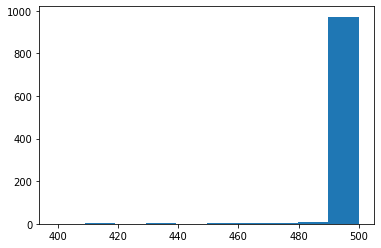

In [20]:
plt.hist(episode_rewards)

In [21]:
agent.policy_network.state_dict()

OrderedDict([('input_layer.weight',
              tensor([[-0.1994,  0.1353,  0.1600,  0.3063],
                      [ 0.3256, -0.1400,  0.4060,  0.1669],
                      [-0.0010, -0.3522,  0.3870, -0.2000],
                      [-0.2066,  0.3354,  0.4976, -0.4269],
                      [-0.3998, -0.3609, -0.0830, -0.6328],
                      [ 0.2482,  0.2487, -0.4317, -0.3149],
                      [-0.0223,  0.1453, -0.1667, -0.1945],
                      [-0.3056,  0.3136,  0.8232,  0.2452],
                      [ 0.0820,  0.1227,  0.9625,  0.5969],
                      [-0.2469,  0.2421,  0.0450,  0.3679],
                      [-0.1733, -0.3154, -0.5466, -0.2301],
                      [-0.2824, -0.1315,  0.5698,  0.3459],
                      [ 0.3083,  0.5678,  0.6660,  0.2711],
                      [ 0.1669,  0.0017,  0.4340,  0.0397],
                      [-0.4403, -0.3519, -0.2125, -0.1339],
                      [-0.0331, -0.5045, -0.1691,  0.0294],
    